In [1]:
import numpy as np
from pandas import read_csv, DataFrame, concat
import matplotlib.pyplot as plt 

from gower import gower_matrix

from sklearn.cluster import DBSCAN, HDBSCAN
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors as knn
from sklearn.metrics import silhouette_score, rand_score
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest

from scipy.spatial.distance import squareform as sf

import seaborn as sns

from kneed import KneeLocator

# utils is a file with some useful functions
from utils import *

In [2]:
# Set common properties for a scientific paper with two-column format
plt.rcParams.update({
    'font.size': 8,              # Global font size
    'axes.titlesize': 10,        # Title font size
    'axes.labelsize': 8,         # Axes labels font size
    'xtick.labelsize': 8,        # X-tick labels font size
    'ytick.labelsize': 8,        # Y-tick labels font size
    'legend.fontsize': 8,        # Legend font size
    'figure.titlesize': 10,      # Figure title font size
    'lines.linewidth': 1.0,      # Line width
    'axes.linewidth': 0.8,       # Axes border width
    'xtick.major.width': 0.8,    # Major tick width
    'ytick.major.width': 0.8,    # Major tick width
    'xtick.minor.width': 0.6,    # Minor tick width
    'ytick.minor.width': 0.6,    # Minor tick width
    'xtick.major.size': 3,       # Major tick size
    'ytick.major.size': 3,       # Major tick size
    'xtick.minor.size': 2,       # Minor tick size
    'ytick.minor.size': 2,       # Minor tick size
    'legend.loc': 'best',        # Legend location
    'savefig.dpi': 300,          # Save figure resolution
    'figure.figsize': [7.5, 3.5] # Figure size in inches (adjust as needed)
})

# UNSUPERVISED LEARNING: final project

In this notebook is reported all the code used to analize the dataset, implement the methods and obtain the results

### Table of contents:
1. [Explore the dataset](#explore)

2. [Gower distance: proximity matrix](#proximity-matrix)

3. [Isolation Forest](#isolation-forest)

4. [Clustering solutions: DBSCAN and HDBSCAN](#clusters)

5. [Distance-based Outlier detection with Gower's distance](#distance-based)
 - [K-Nearest Neighbors](#knn)
 - [Local Outlier Factor](#local-outlier-factor)

7. [One-Class SVM](#one-class-svm)

8. [Final anomalies scores](#final-score)

# Explore Data  <a class="anchor" id="explore"></a>

In [3]:
# unpack data
data_raw = read_csv("Unsupervised Learning 23-24 - Project Dataset.csv", delimiter=";", decimal=",")
# last two columns are all NA, first column is not a variable -> remove
X_raw = data_raw.drop(columns=[ data_raw.columns[len(data_raw.columns)-1], data_raw.columns[len(data_raw.columns)-2], "Row"], inplace=False)
X_raw.head() # take a look

Dim_0  Dim_1=0  Dim_2=0  Dim_3=0  Dim_4=0  Dim_5=0  Dim_6=0  Dim_7=0  \
0  0.750000        1        0        1        1        1        1        1   
1  0.239583        1        1        1        1        1        1        1   
2  0.479167        1        1        1        1        1        1        1   
3  0.656250        0        1        1        1        1        1        1   
4  0.229167        1        1        1        1        1        1        1   

   Dim_8=0  Dim_9=0  ...  Dim_11=0  Dim_12=0  Dim_13=0  Dim_14=0  Dim_15=0  \
0        0        1  ...         1         1         1         1         1   
1        1        1  ...         1         1         1         1         1   
2        1        1  ...         1         1         1         1         1   
3        1        1  ...         1         1         1         1         1   
4        1        1  ...         1         1         1         1         1   

     Dim_16    Dim_17    Dim_18    Dim_19    Dim_20  
0  0.001132  0.080780  0.197324  0.300926  0.225000  
1  0.000472  0.164345  0.235786  0.537037  0.165625  
2  0.003585  0.130919  0.167224  0.527778  0.118750  
3  0.001698  0.091922  0.125418  0.337963  0.129688  
4  0.000472  0.142061  0.229097  0.337963  0.235938  

[5 rows x 21 columns]

In [4]:
N, M = X_raw.shape # dataset size
print("The dataset is composed by %d points with %d attributes" % (N,M))

The dataset is composed by 7200 points with 21 attributes


### Analyse variables types:
Dim_0, Dim_16, Dim_17, Dim_18, Dim_19 and Dim_20 are continuous. Others are binary.

In [5]:
# single out continuous variables and binary variables
continuous = ["Dim_0", "Dim_16", "Dim_17", "Dim_18", "Dim_19", "Dim_20"]
# all non-continuous variables are binary
binary = [c for c in X_raw.columns if c not in continuous]

### A little of statistics

In [6]:
# missing values are present?
mv=False
for att in continuous+binary:
    n_na=X_raw[att].isna().sum()
    if n_na != 0:
        print(f"The attribute {att} has {n_na} missing values")
        mv=True

if not mv:
    print("No missing values detected")

No missing values detected


In [7]:
# take some statistics of the attributes
stats_c={} # continuous variables statistics
for c in continuous:
    stats_c[c] = {
        "mean": X_raw[c].mean(),
        "std": X_raw[c].std(),
        "first_quartile": X_raw[c].quantile(0.25), # IQR
        "median": X_raw[c].median(),
        "third_quartile": X_raw[c].quantile(0.75), # IQR
        "max": X_raw[c].max(),
        "min": X_raw[c].min()
    }
stats_c = DataFrame(stats_c) # easier visualization

stats_b={} # binary variables statistics
for b in binary:
    stats_b[b]={
        "count ones": (X_raw[b]==1).sum(),
        "count zeros": (X_raw[b]==0).sum()
    }
stats_b = DataFrame(stats_b) # easier visualization

In [8]:
stats_c

Dim_0    Dim_16    Dim_17    Dim_18    Dim_19    Dim_20
mean            0.531790  0.009172  0.108506  0.179649  0.374250  0.173773
std             0.197156  0.043357  0.042001  0.060148  0.088354  0.056402
first_quartile  0.375000  0.001340  0.091922  0.145485  0.324074  0.145312
median          0.562500  0.003208  0.109192  0.175585  0.370370  0.170313
third_quartile  0.687500  0.005094  0.119777  0.205686  0.402778  0.195313
max             1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
min             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000

In [9]:
stats_b

Dim_1=0  Dim_2=0  Dim_3=0  Dim_4=0  Dim_5=0  Dim_6=0  Dim_7=0  \
count ones      5009     6260     7089     7108     6924     7122     7099   
count zeros     2191      940      111       92      276       78      101   

             Dim_8=0  Dim_9=0  Dim_10=0  Dim_11=0  Dim_12=0  Dim_13=0  \
count ones      7079     6728      6705      7109      7141      7016   
count zeros      121      472       495        91        59       184   

             Dim_14=0  Dim_15=0  
count ones       7199      6848  
count zeros         1       352

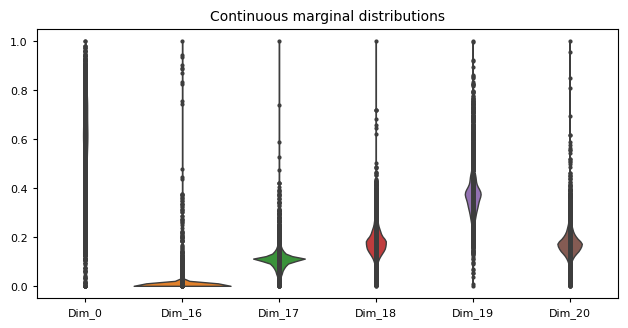

In [10]:
fig = plt.figure()
plt.title("Continuous marginal distributions")
sns.violinplot(X_raw[continuous], linewidth=1, inner="point", width=1, cut=0)
plt.show()

fig.savefig("figures/continuous_distributions.jpg")

c:\Users\diego_pbzho83\.conda\envs\UnsupervisedL\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


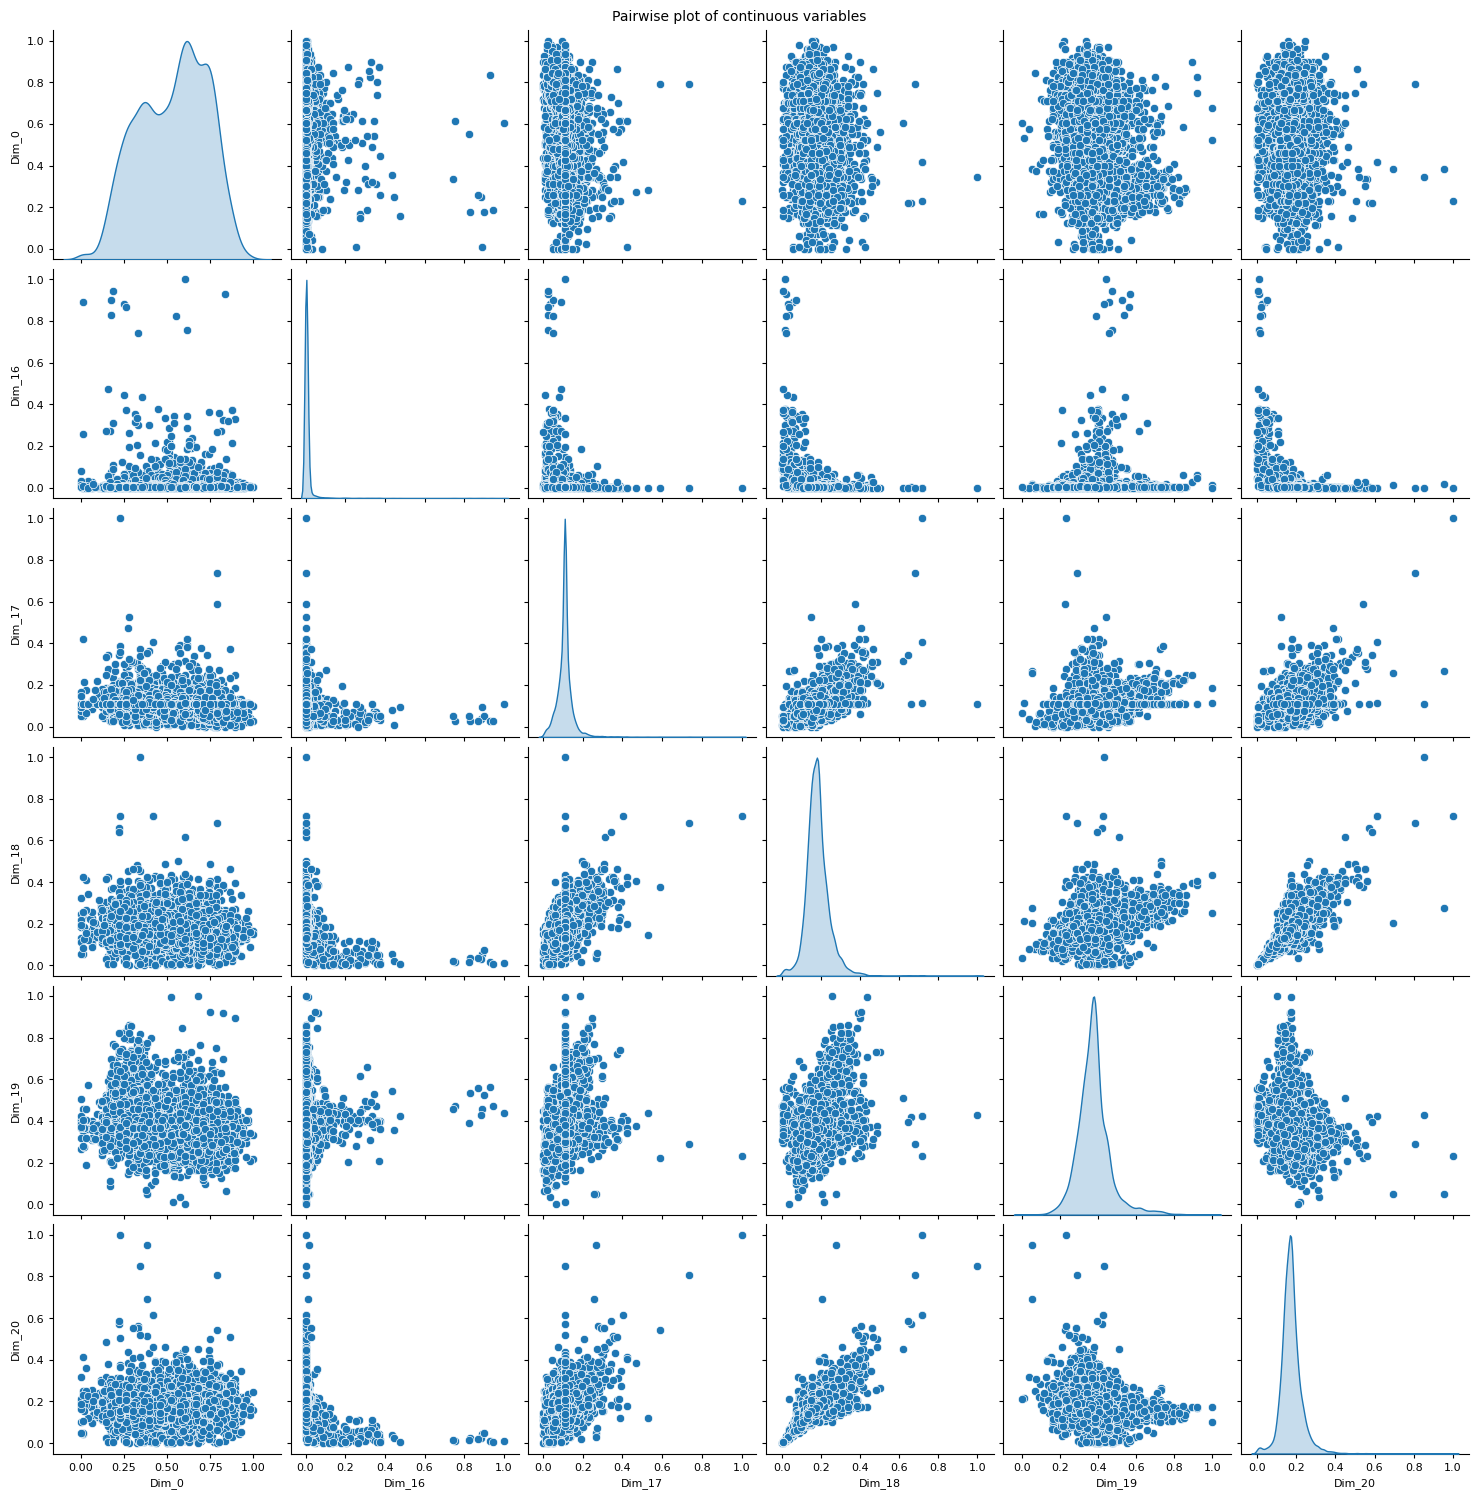

In [11]:
g=sns.pairplot(X_raw[continuous], diag_kind="kde")
g.fig.suptitle("Pairwise plot of continuous variables", y=1)
plt.show()

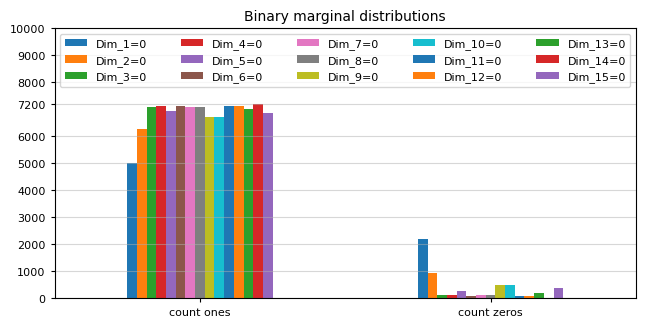

In [12]:
# Plot the binary variables in a barplot
fig = plt.figure()
plt.title("Binary marginal distributions")

stats_b.plot.bar(stacked=False, ax=fig.gca())
plt.grid(alpha=0.5, axis="y")
plt.legend( mode ="expand", ncol=5)

yticks  = [i for i in range(0, 10001,1000)]
# substitute 7000 with 7200
yticks.remove(7000)
yticks.append(7200)
#yticks[np.where(yticks == 7000)] = 7200
plt.yticks(yticks)
plt.xticks(rotation=0)

plt.show()

# save the plot
fig.savefig("figures/binary_distributions.jpg")

In [13]:
X = X_raw.drop(columns=["Dim_14=0"], inplace=False)
N, M = X.shape
binary.remove("Dim_14=0")

X.head()

Dim_0  Dim_1=0  Dim_2=0  Dim_3=0  Dim_4=0  Dim_5=0  Dim_6=0  Dim_7=0  \
0  0.750000        1        0        1        1        1        1        1   
1  0.239583        1        1        1        1        1        1        1   
2  0.479167        1        1        1        1        1        1        1   
3  0.656250        0        1        1        1        1        1        1   
4  0.229167        1        1        1        1        1        1        1   

   Dim_8=0  Dim_9=0  Dim_10=0  Dim_11=0  Dim_12=0  Dim_13=0  Dim_15=0  \
0        0        1         1         1         1         1         1   
1        1        1         1         1         1         1         1   
2        1        1         1         1         1         1         1   
3        1        1         1         1         1         1         1   
4        1        1         1         1         1         1         1   

     Dim_16    Dim_17    Dim_18    Dim_19    Dim_20  
0  0.001132  0.080780  0.197324  0.300926  0.225000  
1  0.000472  0.164345  0.235786  0.537037  0.165625  
2  0.003585  0.130919  0.167224  0.527778  0.118750  
3  0.001698  0.091922  0.125418  0.337963  0.129688  
4  0.000472  0.142061  0.229097  0.337963  0.235938

---
---

# Proximity matrix  <a class="anchor" id="proximity-matrix"></a>

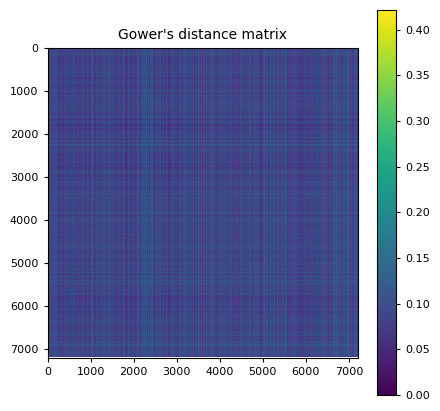

In [14]:
# Proximity matrix for mixed variable types
# Reference paper: https://www.jstor.org/stable/2528823?seq=1
GM = gower_matrix(data_x=X)
# Show distance matrix
plt.figure(figsize=(5,5))
imshow(GM, "Gower's distance matrix")
plt.show()

### Histogram of Proximity Matrix

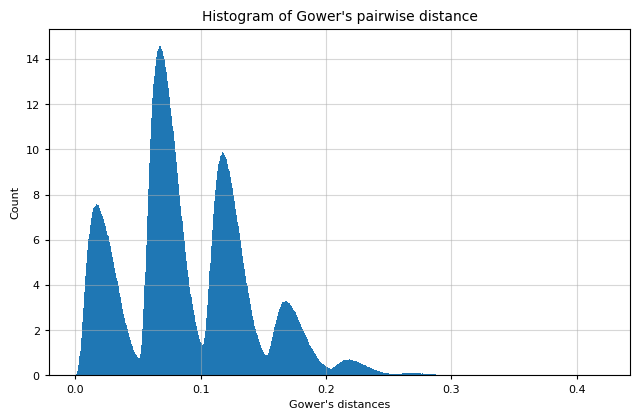

In [15]:
# GM has a total of N*(N-1)/2 free parameters, that is around 26 million values 
# show pairwise distances histogram
fig = plt.figure(figsize=(7.5,4.5))
histogram(sf(GM), 1000, title="Histogram of Gower's pairwise distance", labelx="Gower's distances", labely="Count", grid=True, density=True)
plt.show()

fig.savefig(f"figures/gower_histogram.jpg")

In [16]:
# tsne_results = np.load("tsne_results.npz")["tsne_results"]
# Load the tsne model -> we trained it only one time with the code below
tsne = TSNE(n_components=2, verbose=0, perplexity=100, n_iter=1000, metric="precomputed", init="random")
tsne_results = tsne.fit_transform(GM) # fit the model on the distance matrix

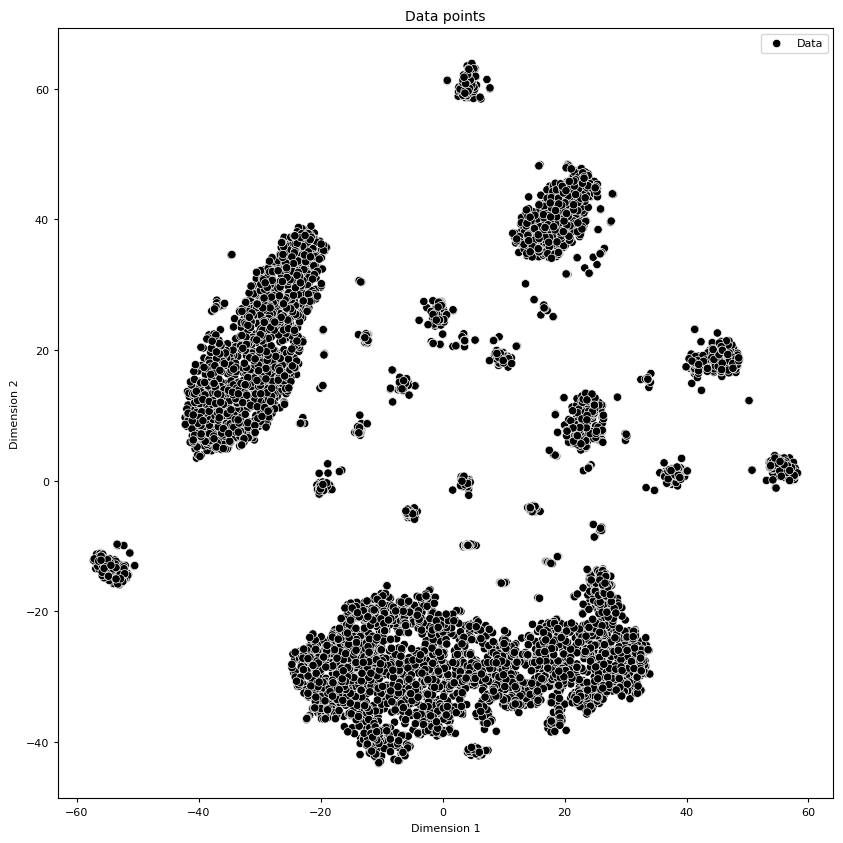

In [17]:
figure = tSNE_plot(tsne_results, np.repeat(1,N), ["Data"], "Data points") # plot data

---
---

# Isolation forest <a class="anchor" id="isolation-forest"></a>

In [18]:
X_if = X.copy()
if_model = IsolationForest(n_estimators=2000, random_state= 10200).fit(X_if.to_numpy())
if_anomalies = if_model.predict(X_if.to_numpy())==-1

In [19]:
#Get scores from if_model
if_scores = if_model.decision_function(X_if.to_numpy())

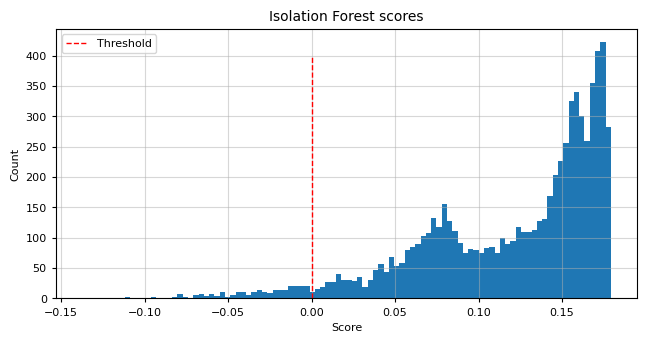

In [20]:
fig = plt.figure()
histogram(if_scores, title="Isolation Forest scores", bins=100, grid=True, labelx="Score", labely="Count")
plt.vlines(0, 0, 400, colors="red", linestyles="dashed", label="Threshold")
plt.legend()
plt.show()
fig.savefig("figures/IF_scores.jpg")

In [22]:
print(f"Isolation Forest found {100*np.sum(if_anomalies)/N:.2f} % of anomalies")

Isolation Forest found 3.74 % of anomalies


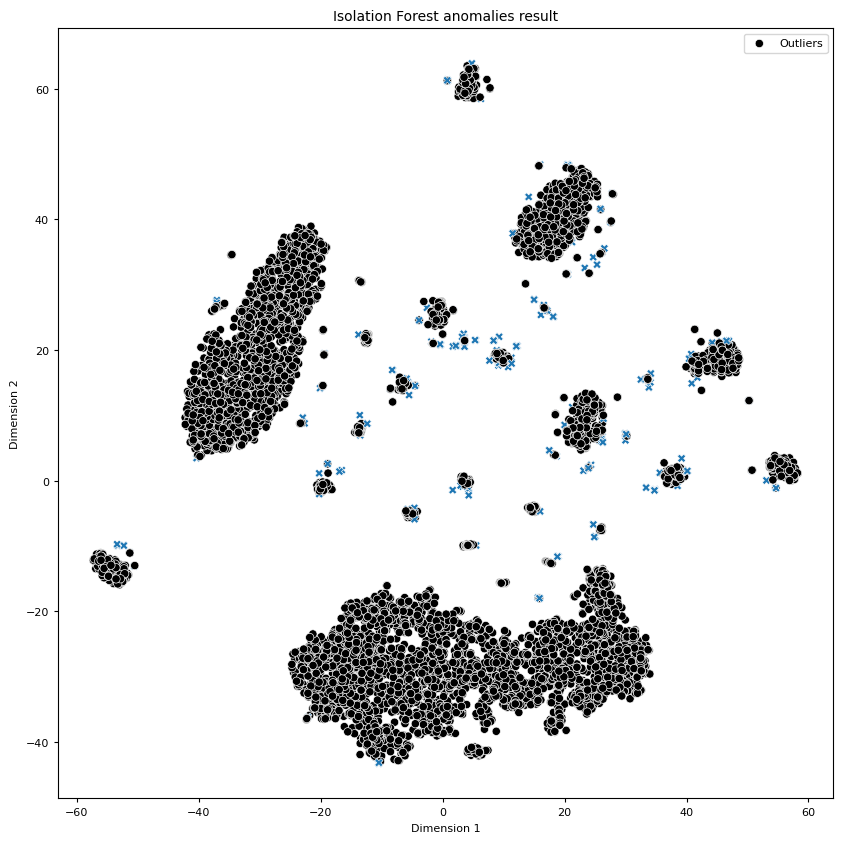

In [23]:
# show isolation forest results
tSNE_plot(tsne_results, if_anomalies, title="Isolation Forest anomalies result")

---
---

# DBSCAN and HDBSCAN clustering with Gower's distance  <a class="anchor" id="clusters"></a>

In [24]:
# Set the common parameter for DBSCAN and HDBSCAN
MinPts = np.arange(2,51,2)

In [25]:
# DBSCAN
dbscan_list = []
# We will get epsilons for each MinPts by using knn and knee locator
for mp in MinPts:
    neigh = knn(n_neighbors=mp, metric='precomputed').fit(GM) #Knn using Gower matrix
    distances, _ = neigh.kneighbors(GM)
    distances = np.sort(distances[:, -1])
    # Find the knee point
    knee = KneeLocator(range(len(distances)), distances, S=1.0, curve='convex', direction='increasing', interp_method='polynomial')
    
    dbscan = DBSCAN(eps=distances[knee.knee], min_samples=mp, metric='precomputed').fit(GM)
    dbscan_list.append([mp, dbscan])
   
# HDBSCAN
# We use the same MinPts as in DBSCAN
hdbscan_list = []
for mp in MinPts:   
    hdbscan = HDBSCAN(min_cluster_size=mp, metric='precomputed').fit(GM)
    hdbscan_list.append([mp, hdbscan])

In [26]:
# Compare the clustering solution for DBSCAN and HDBSCAN using the silhouette score
silhouette_scores = []
silhouette_scores_no_outliers = []

for dbscan in dbscan_list:
    silhouette_scores.append(silhouette_score(GM, dbscan[1].labels_,metric='precomputed'))
    #compute the silhouette score without the outliers
    dbscan_anomalies = np.array(dbscan[1].labels_ == -1)
    GM_no_outliers = GM[dbscan_anomalies == False, :][:, dbscan_anomalies == False]
    silhouette_scores_no_outliers.append(silhouette_score(GM_no_outliers, dbscan[1].labels_[dbscan_anomalies == False], metric='precomputed'))
    
silhouette_scores_hdbscan = []
silhouette_scores_no_outliers_hdbscan = []
for hdbscan in hdbscan_list:
    silhouette_scores_hdbscan.append(silhouette_score(GM, hdbscan[1].labels_, metric='precomputed'))
    #compute the silhouette score without the outliers
    hdbscan_anomalies = np.array(hdbscan[1].labels_ == -1)
    GM_no_outliers_hdbscan = GM[hdbscan_anomalies == False, :][:, hdbscan_anomalies == False]
    silhouette_scores_no_outliers_hdbscan.append(silhouette_score(GM_no_outliers_hdbscan, hdbscan[1].labels_[hdbscan_anomalies == False], metric='precomputed'))

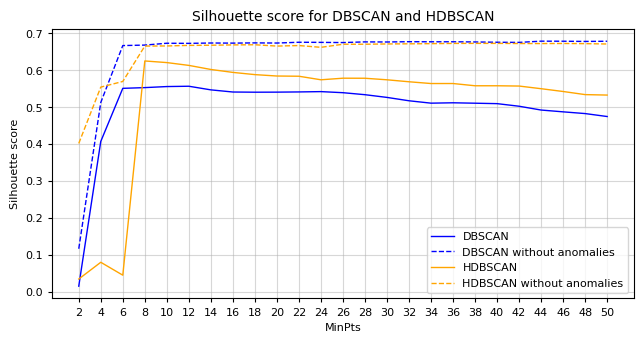

In [27]:
# save all the results in a single plot
fig = plt.figure()
plt.plot(MinPts, silhouette_scores, label ="DBSCAN", linestyle='solid', color = 'blue')
plt.plot(MinPts, silhouette_scores_no_outliers, label ="DBSCAN without anomalies", linestyle='dashed', color = 'blue')
plt.plot(MinPts, silhouette_scores_hdbscan, label ="HDBSCAN", linestyle='solid', color = 'orange')
plt.plot(MinPts, silhouette_scores_no_outliers_hdbscan, label ="HDBSCAN without anomalies", linestyle='dashed', color = 'orange')
plt.title("Silhouette score for DBSCAN and HDBSCAN")
plt.xlabel("MinPts")
plt.ylabel("Silhouette score")
plt.xticks(MinPts)
plt.legend()
plt.grid(alpha=0.5)
plt.show()

fig.savefig("figures/silhouette_scores_all2.jpg")

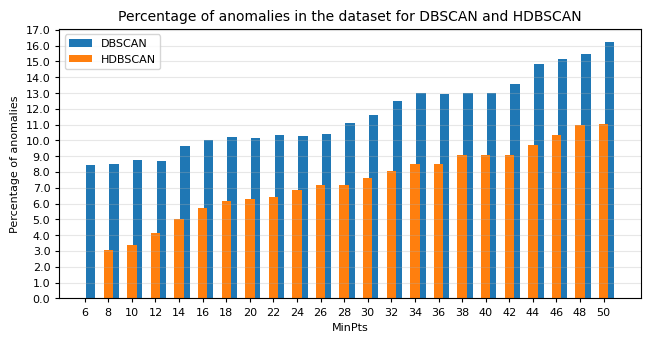

In [35]:
# Compute the percentage of anomalies in the dataset for each clustering solution of HDBSCAN and DBSCAN
anomalies = []
for dbscan in dbscan_list:
    anomalies.append(np.sum(dbscan[1].labels_ == -1) / N)
anomalies_hdbscan = []
for hdbscan in hdbscan_list:
    anomalies_hdbscan.append(np.sum(hdbscan[1].labels_ == -1) / N)
    

#plot it in a barplot
fig = plt.figure()
plt.bar(MinPts[2:]+ 0.5, anomalies[2:], label = "DBSCAN")
plt.bar(MinPts[3:], anomalies_hdbscan[3:], label = "HDBSCAN")
plt.title("Percentage of anomalies in the dataset for DBSCAN and HDBSCAN")
plt.xlabel("MinPts")
plt.ylabel("Percentage of anomalies")
plt.xticks(MinPts[2:])
y_pos_ticks = np.arange(0, 0.171, 0.01)
plt.yticks(y_pos_ticks, [str(round(100*y, 2)) for y in y_pos_ticks])
plt.legend()
plt.grid(alpha=0.3, axis="y")
plt.show()

fig.savefig("figures/anomalies-DB-HDBSCAN.jpg")


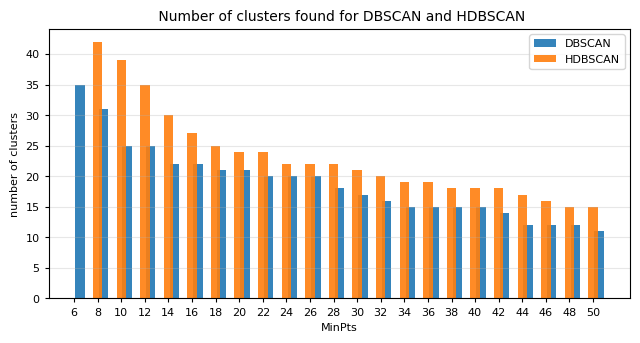

In [36]:
# Plot the  number of clusters for DBSCAN and HDBSCAN 
skip = 3 # skip the firsts MinPts

n_clusters = []
n_clusters_hdbscan = []
for dbscan, hdbscan in zip(dbscan_list, hdbscan_list):
    n_clusters.append(len(np.unique(dbscan[1].labels_)) -1)  # -1 to exclude the outliers
    n_clusters_hdbscan.append(len(np.unique(hdbscan[1].labels_))-1)

fig = plt.figure()
plt.bar(MinPts[skip-1:]+ 0.5, n_clusters[skip-1:], label = "DBSCAN", alpha=0.9)
plt.bar(MinPts[skip:], n_clusters_hdbscan[skip:], label = "HDBSCAN", alpha=0.9)
plt.title(" Number of clusters found for DBSCAN and HDBSCAN")
plt.xlabel("MinPts")
plt.ylabel("number of clusters")
plt.xticks(MinPts[skip-1:])
plt.legend()
plt.grid(alpha=0.3, axis="y")
plt.show()

fig.savefig("figures/number_clusters-DB-HDBSCAN.jpg")


In [37]:
# Get the values of the clustering solution with less anomalies for HDBSCAN
print(f"minimum anomalies for DBSCAN: {100*np.min(anomalies):.2f}%")
print(f"minimum anomalies for HDBSCAN: {100*np.min(anomalies_hdbscan):.2f}%")
hdbscan = hdbscan_list[np.argmin(anomalies_hdbscan)][1]
dbscan = dbscan_list[np.argmin(anomalies)][1]

# save the anomalies for each best result
#dbscan_anomalies = np.array(dbscan.labels_ == -1)
#hdbscan_anomalies = np.array(hdbscan.labels_ == -1)

minimum anomalies for DBSCAN: 8.42%
minimum anomalies for HDBSCAN: 3.04%


Number of clusters for DBSCAN with minpts=14: 22
Number of clusters for HDBSCAN with minpts=14: 30
Percentage of anomalies for DBSCAN with minpts=14: 9.64%
Percentage of anomalies for HDBSCAN with minpts=14: 5.01%


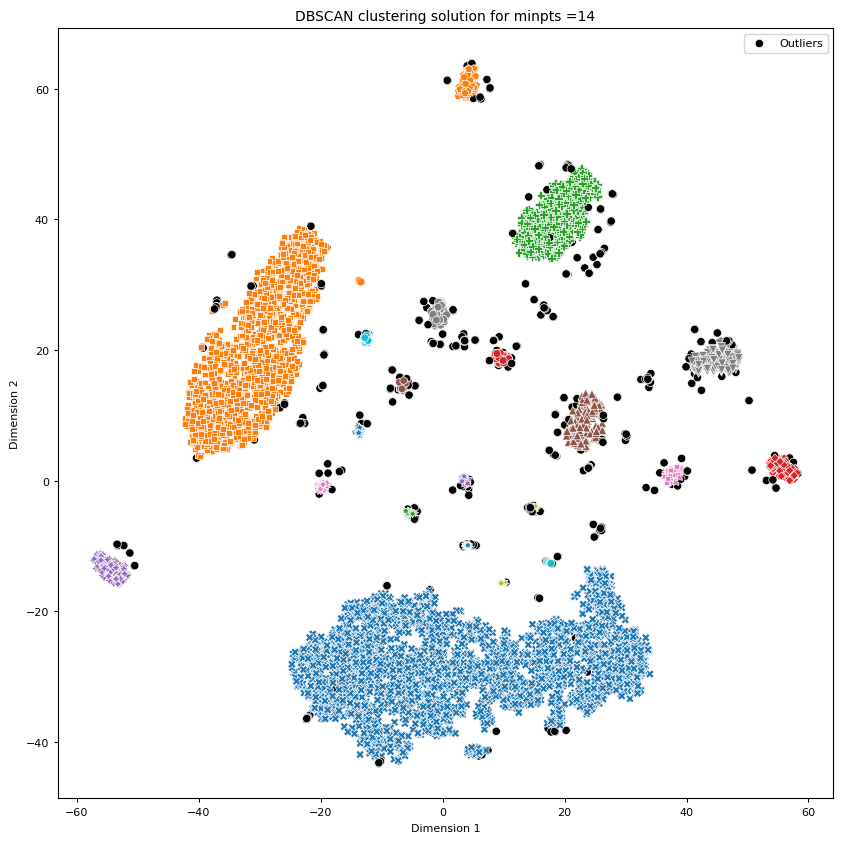

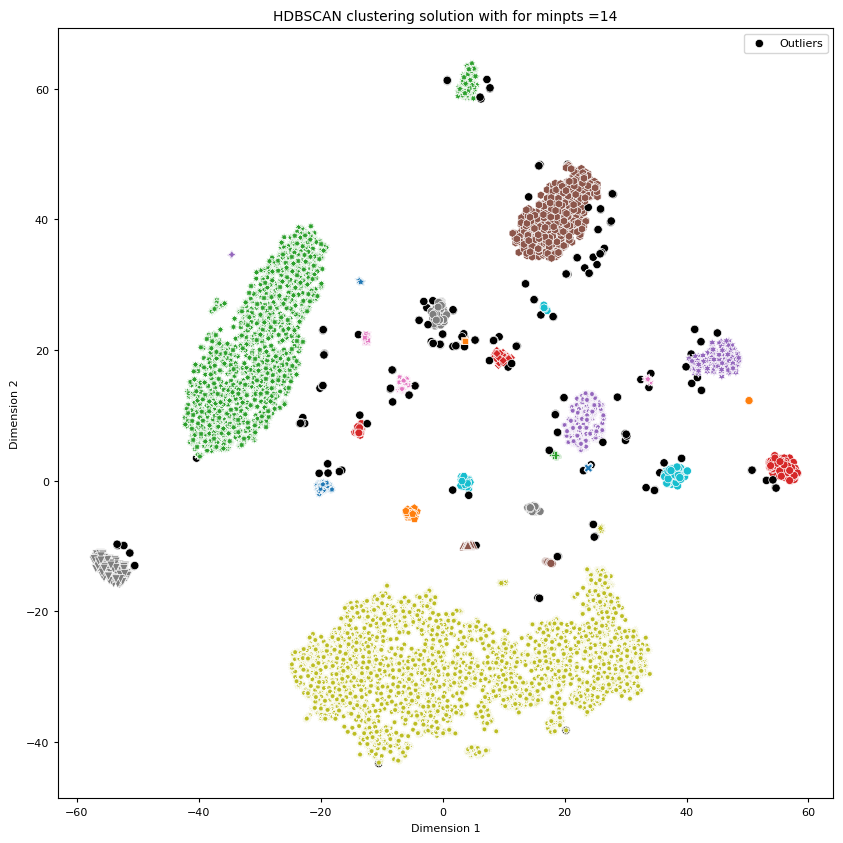

In [44]:
# Show the results in a plot

# Choose the number of minpts to display
minpts = 14
# MinPts = index*2 +2
index = (minpts-2)//2
dbscan = dbscan_list[index][1]
hdbscan = hdbscan_list[index][1]


# Create a directory to save the results 
import os

try:
    os.mkdir("DBSCAN_results/minpts_"+str(minpts)+"/")
    os.mkdir("HDBSCAN_results/minpts_"+str(minpts)+"/")
except:
    pass

# Print the number of clusters and the percentage of anomalies for the chosen minpts
print(f"Number of clusters for DBSCAN with minpts={minpts}: {len(np.unique(dbscan.labels_))-1}")
print(f"Number of clusters for HDBSCAN with minpts={minpts}: {len(np.unique(hdbscan.labels_))-1}")
dbscan_anomalies = np.array(dbscan.labels_ == -1)
hdbscan_anomalies = np.array(hdbscan.labels_ == -1)
print(f"Percentage of anomalies for DBSCAN with minpts={minpts}: {100*np.sum(dbscan_anomalies)/N:.2f}%")
print(f"Percentage of anomalies for HDBSCAN with minpts={minpts}: {100*np.sum(hdbscan_anomalies)/N:.2f}%")


fig1 = tSNE_plot(tsne_results, dbscan.labels_, title=f"DBSCAN clustering solution for minpts ={minpts}", return_plot=True)
fig2 = tSNE_plot(tsne_results, hdbscan.labels_, title=f"HDBSCAN clustering solution with for minpts ={minpts}", return_plot=True)

fig1.savefig(f"DBSCAN_results/minpts_{minpts}/tSNE.jpg")
fig2.savefig(f"HDBSCAN_results/minpts_{minpts}/tSNE.jpg")

In [45]:
# OBTAIN intra and inter cluster distances for the selected solutions

# DBSCAN
db_intra = intra_cluster_distances(dbscan.labels_, GM)
db_inter = inter_cluster_distances(dbscan.labels_, GM)

# HDBSCAN
hdb_intra = intra_cluster_distances(hdbscan.labels_, GM)
hdb_inter = inter_cluster_distances(hdbscan.labels_, GM)

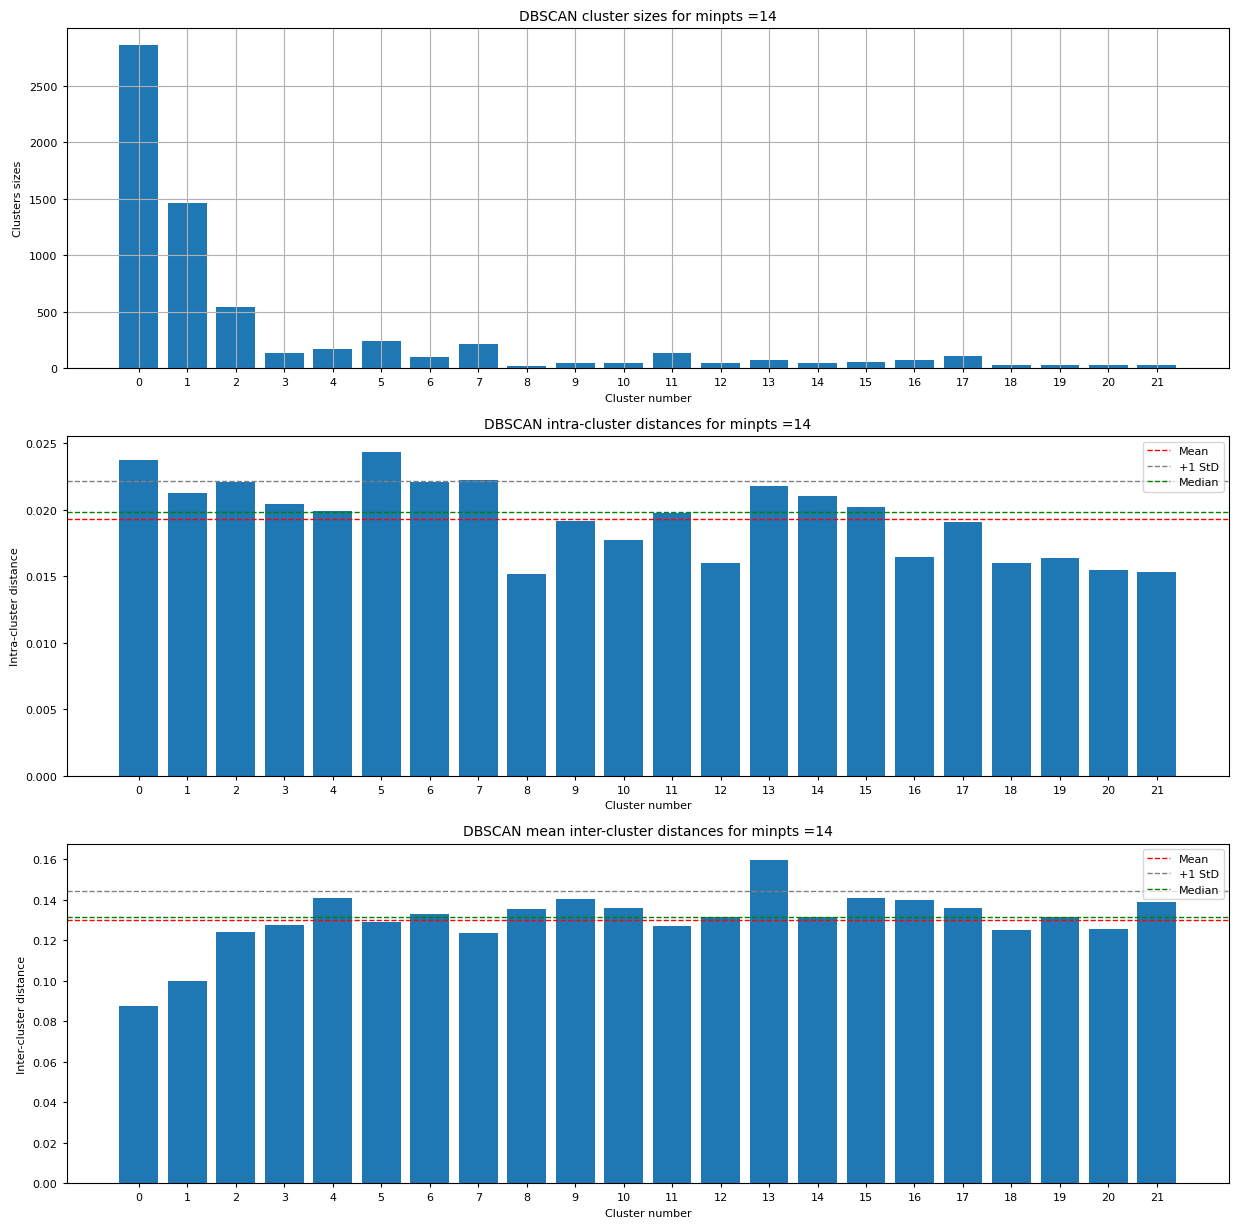

In [46]:
# Plots for dbscan

cluster_sizes=[]
Kd = max(dbscan.labels_)+1
db_labels = dbscan.labels_
for k in range(Kd):
    cluster_sizes.append( (db_labels==k).sum() )

fig = plt.figure(figsize=(15,15))
# Show the size of the found cluster

ax = plt.subplot(3,1,1)
barplot(np.arange(Kd), cluster_sizes, title=f"DBSCAN cluster sizes for minpts ={minpts}", labely="Clusters sizes",labelx="Cluster number", xticks=range(Kd), yticks=range(0,3000,500), grid=True)

# Show the intra cluster distance for each cluster
plt.subplot(3,1,2,sharex=ax)
barplot(np.arange(Kd), db_intra, title=f"DBSCAN intra-cluster distances for minpts ={minpts}", labelx="Cluster number",labely="Intra-cluster distance", grid=False)
mean_intra = np.average(db_intra)
std_intra = np.std(db_intra)
median_inter = np.median(db_intra)
plt.axhline(y=mean_intra, linestyle='--', c="red")
plt.axhline(y=mean_intra+std_intra, linestyle='--', c="gray")
plt.axhline(y=median_inter, linestyle='--', c="green")
plt.legend(["Mean", "+1 StD", "Median"])

# Show the median cluster distance of each cluster
avg_inter_dist=np.mean(db_inter,axis=0)
plt.subplot(3,1,3,sharex=ax)
barplot(range(Kd), avg_inter_dist, title=f"DBSCAN mean inter-cluster distances for minpts ={minpts}", labelx="Cluster number",labely="Inter-cluster distance", grid=False, yticks=[0.02*i for i in range(50)])
mean_inter = np.average(avg_inter_dist)
std_inter = np.std(avg_inter_dist)
median_inter = np.median(avg_inter_dist)
plt.axhline(y=mean_inter, linestyle='--', c="red")
plt.axhline(y=mean_inter+std_inter, linestyle='--', c="gray")
plt.axhline(y=median_inter, linestyle='--', c="green")
plt.legend(["Mean", "+1 StD", "Median"])
plt.show()

fig.savefig(f"DBSCAN_results/minpts_{minpts}/cluster_stats.jpg")

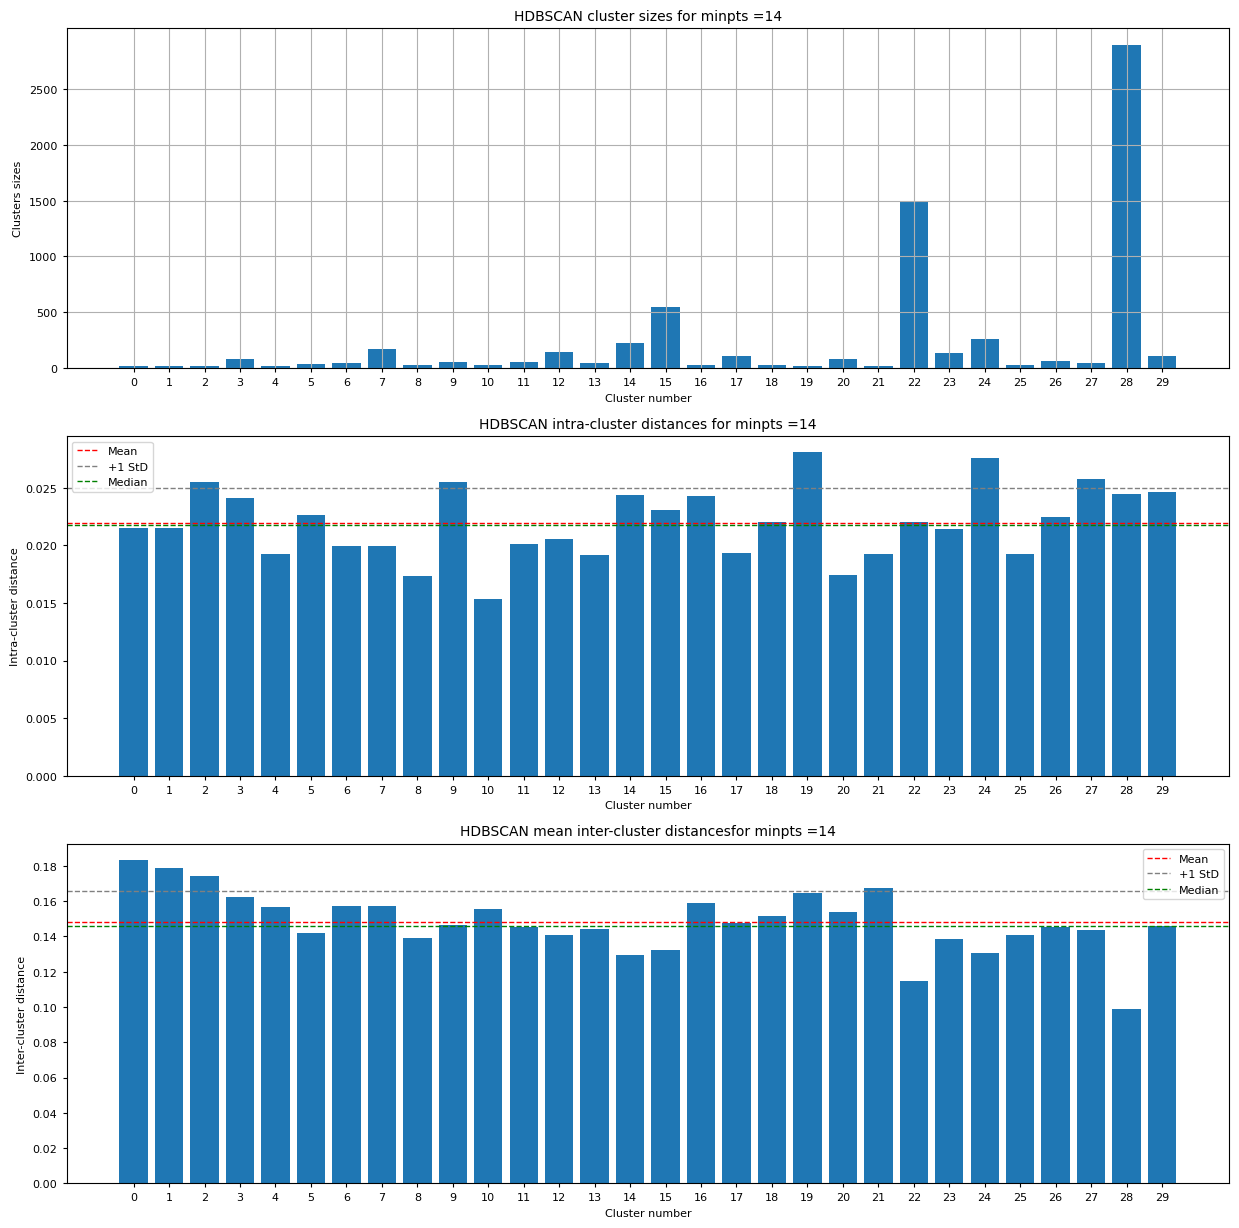

In [47]:
# Plots for hdbscan
cluster_sizes=[]
Kd = max(hdbscan.labels_)+1
db_labels = hdbscan.labels_
for k in range(Kd):
    cluster_sizes.append( (db_labels==k).sum() )

fig = plt.figure(figsize=(15,15))
# Show the size of the found cluster

ax = plt.subplot(3,1,1)
barplot(np.arange(Kd), cluster_sizes, title=f"HDBSCAN cluster sizes for minpts ={minpts}" , labely="Clusters sizes",labelx="Cluster number", xticks=range(Kd), yticks=range(0,3000,500), grid=True)

# Show the intra cluster distance for each cluster
plt.subplot(3,1,2,sharex=ax)
barplot(np.arange(Kd), hdb_intra, title=f"HDBSCAN intra-cluster distances for minpts ={minpts}", labelx="Cluster number",labely="Intra-cluster distance", grid=False)
mean_intra = np.average(hdb_intra)
std_intra = np.std(hdb_intra)
median_inter = np.median(hdb_intra)
plt.axhline(y=mean_intra, linestyle='--', c="red")
plt.axhline(y=mean_intra+std_intra, linestyle='--', c="gray")
plt.axhline(y=median_inter, linestyle='--', c="green")
plt.legend(["Mean", "+1 StD", "Median"])

# Show the median cluster distance of each cluster
avg_inter_dist=np.mean(hdb_inter,axis=0)
plt.subplot(3,1,3,sharex=ax)
barplot(range(Kd), avg_inter_dist, title=f"HDBSCAN mean inter-cluster distancesfor minpts ={minpts}", labelx="Cluster number",labely="Inter-cluster distance", grid=False, yticks=[0.02*i for i in range(50)])
mean_inter = np.average(avg_inter_dist)
std_inter = np.std(avg_inter_dist)
median_inter = np.median(avg_inter_dist)
plt.axhline(y=mean_inter, linestyle='--', c="red")
plt.axhline(y=mean_inter+std_inter, linestyle='--', c="gray")
plt.axhline(y=median_inter, linestyle='--', c="green")
plt.legend(["Mean", "+1 StD", "Median"])
plt.show()

fig.savefig(f"HDBSCAN_results/minpts_{minpts}/cluster_stats.jpg")

---
---

# Distance-based Outlier detection with Gower's distance <a class="anchor" id="distance-based"></a>

## K-Nearest Neighbors <a class="anchor" id="knn"></a>

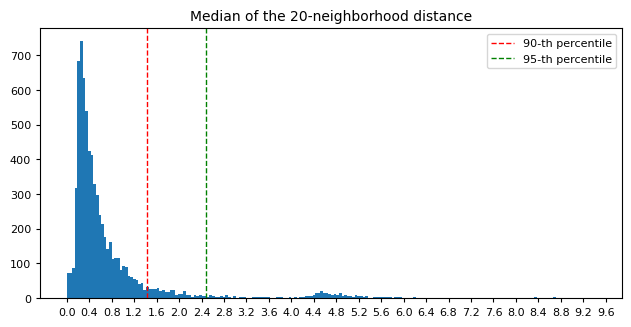

In [77]:
# median has 50% breaking value, hence if I take roughly twice the size of the smallest cluster in DBSCAN
# I should be robust wrt marking little clusters as outliers (besides little clusters far from every other point!!)
k = 20 # in this way we can detect as outliers the data that has more than k/2 points far away
neighborhood_set = knn(n_neighbors=k, metric="precomputed").fit(GM) #KNN with Gower's distance
dist, _= neighborhood_set.kneighbors(GM) # Extract distance for neighbors

median_neigh_dist = np.median(dist[:,range(1,k)],axis=1).reshape((-1,1)) # take the media of the knns distances
# in order to compare it in various tries we standardize it and shift it to the positive axis
z_scores_median = (median_neigh_dist-np.mean(median_neigh_dist))/np.std(median_neigh_dist) # standardize it
z_scores_median = z_scores_median-np.min(z_scores_median) # shift to positive values

# show scores and percentiles
fig = plt.figure()
histogram(z_scores_median, title=f"Median of the {k}-neighborhood distance", bins=200, xticks=[0.4*i for i in range(40)])
plt.axvline(x=np.percentile(z_scores_median, 90), c="red", linestyle="--") 
plt.axvline(x=np.percentile(z_scores_median, 95), c="green", linestyle="--") 
plt.legend(["90-th percentile", "95-th percentile"])

plt.show()



In order to find the better cut for the distribution, we proceeded by plotting the sorted score and detecting the knee points.

In [78]:
sorted_distances = np.sort(z_scores_median, axis=0).reshape(-1)
sorted_indices = np.argsort(z_scores_median, axis=0).reshape(-1)
i = np.arange(len(sorted_distances))

# detect the knee 
knee = KneeLocator(np.arange(len(sorted_distances)), sorted_distances, S=1.0, curve='convex', direction='increasing')
knee_value = sorted_distances[knee.knee]
print(f"Knee value: {knee_value}")

# detect another knee with a different S value
S = 2.5
knee2 = KneeLocator(np.arange(len(sorted_distances)), sorted_distances, S=S, curve='convex', direction='increasing')
knee_value2 = sorted_distances[knee2.knee]
print(f"Knee value with S={S}: {knee_value2}")

Knee value: 5.160141468048096
Knee value with S=2.5: 2.195239543914795


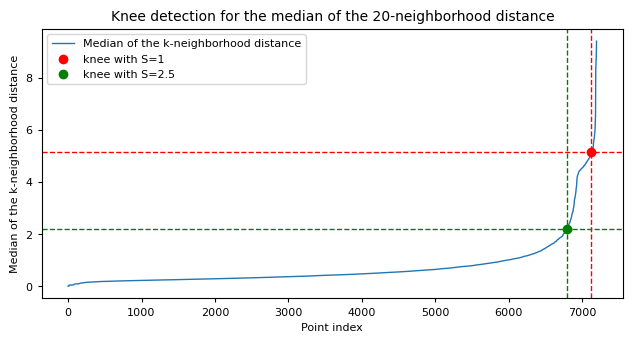

In [84]:
# Plot the knee
fig = plt.figure()
plt.plot(i, sorted_distances, label="Median of the k-neighborhood distance")

# first knee
plt.axvline(knee.knee, c="red", linestyle="--")
plt.axhline(knee_value, c="red", linestyle="--")
plt.plot((knee.knee), (knee_value), 'o', color='r', label = "knee with S=1")

# second knee
plt.axvline(knee2.knee, c="green", linestyle="--")
plt.axhline(knee_value2, c="green", linestyle="--")
plt.plot((knee2.knee), (knee_value2), 'o', color='green', label = f"knee with S={S}")


plt.title(f"Knee detection for the median of the {k}-neighborhood distance")
plt.xlabel("Point index")
plt.ylabel("Median of the k-neighborhood distance")
plt.legend( )
plt.show()

fig.savefig("figures/knee_detection_knn.jpg")

In [80]:
# mark as outliers the points that are above the knee
outliers = z_scores_median > knee_value
print(f"Percentage of outliers with S = 1: {100*np.sum(outliers)/N:.2f}%")

outliers2 = z_scores_median > knee_value2
print(f"Percentage of outliers with S ={S}: {100*np.sum(outliers2)/N:.2f}%")

Percentage of outliers with S = 1: 0.97%
Percentage of outliers with S =2.5: 5.56%


We obtained the graph above by tuning the "S" parameter in the KneeLocator function. Looking at the graph we decided that a good cut could be near the knee with S= 2.5. In order validate the result, we

In [81]:
# cut the knn distance to identify the outliers
cut=2.2
knn_anomalies_scores = z_scores_median
knn_anomalies = np.array(knn_anomalies_scores>cut).squeeze() # every point with knn distance greater than cut is an outlier
# how many outliers?
print(f"Selected {knn_anomalies.sum()} anomalies")

an_perc = knn_anomalies.sum()/N
print(f"Percentages of outliers wrt the total number of points: {100*an_perc:.2f}%")

Selected 400 anomalies
Percentages of outliers wrt the total number of points: 5.56%


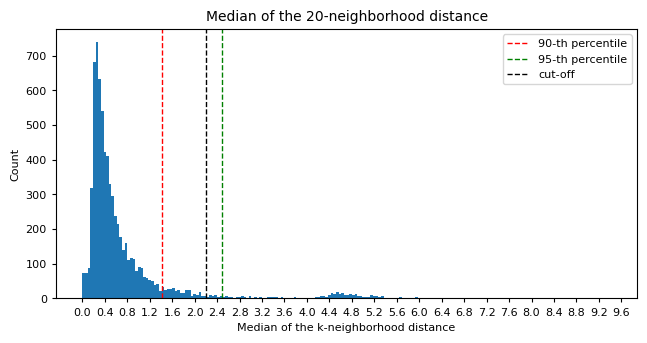

In [82]:
# add the cut to fig
fig = plt.figure()
histogram(z_scores_median, title=f"Median of the {k}-neighborhood distance", bins=200, xticks=[0.4*i for i in range(40)])
plt.axvline(x=np.percentile(z_scores_median, 90), c="red", linestyle="--")
plt.axvline(x=np.percentile(z_scores_median, 95), c="green", linestyle="--")
plt.axvline(x=cut, c="black", linestyle="--")
plt.xlabel("Median of the k-neighborhood distance")
plt.ylabel("Count")
plt.legend(["90-th percentile", "95-th percentile", "cut-off"])
plt.show()

fig.savefig("figures/median_neigh_dist.jpg")

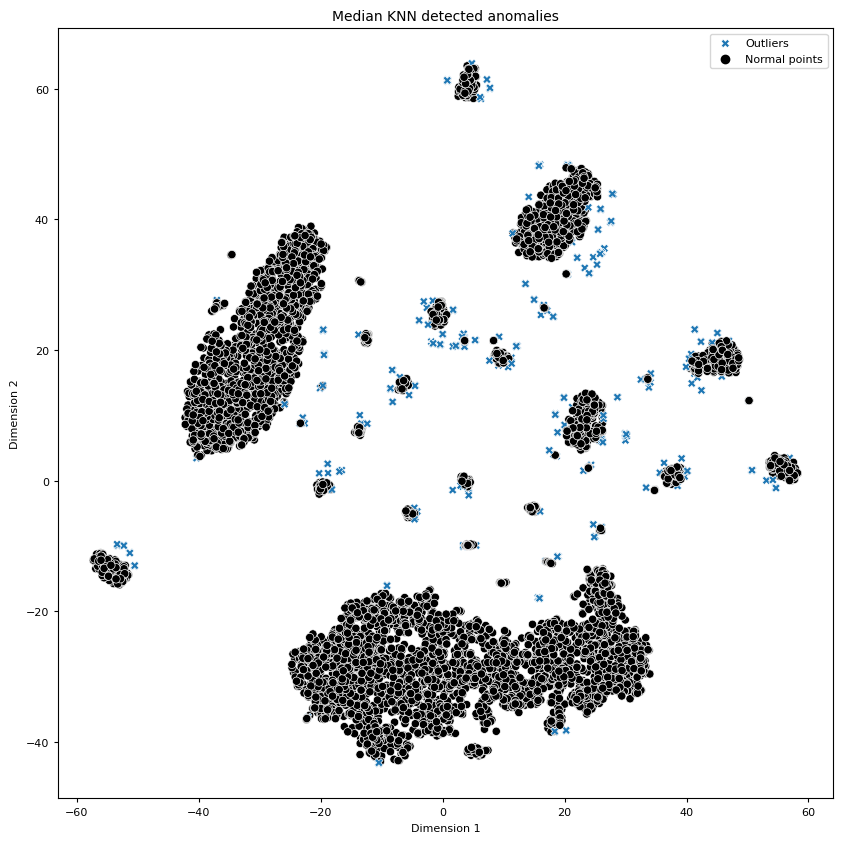

In [83]:
# show KNN results
tSNE_plot(tsne_results, knn_anomalies, ["Outliers", "Normal points"], "Median KNN detected anomalies")

---
---

# Local Outlier Factor <a class="anchor" id="local-outlier-factor"></a>

LOF found 288 anomalies, the LOF score threshold is -2.416


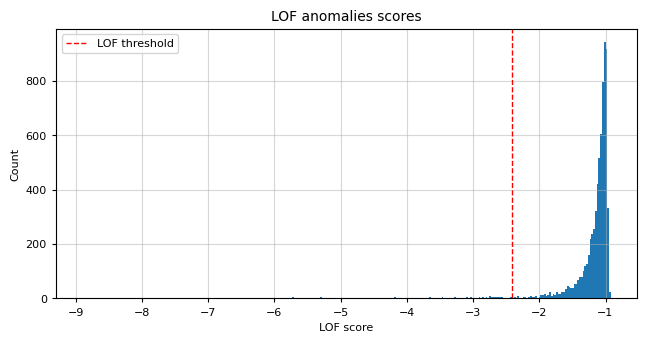

In [56]:
# apply LOF, the amount of outliers are based on HDBSCAN and KNN
lof = LocalOutlierFactor(n_neighbors=14, metric="precomputed", contamination=0.04) 

# LOF with percent of outliers similar to Isolation Forest. 
#from graphical observation on tSNE plot after computing the algorithm we saw that a greater contamination tends to mark as outliers point into the bigger cluster

lof_score = lof.fit_predict(GM) # (N,) array with +1 for inlier and -1 for outliers
lof_anomalies = np.array(lof_score==-1) # array of Boolean, True if anomaly
# anomaly scores
lof_threshold = max(lof.negative_outlier_factor_[lof_anomalies]) 

print(f"LOF found {lof_anomalies.sum()} anomalies, the LOF score threshold is %.3f"%lof_threshold)

# show LOF scores and cutoff
fig  =plt.figure()
histogram(lof.negative_outlier_factor_, title="LOF anomalies scores", bins=300)
plt.axvline(x=lof_threshold, color="red", linestyle="--")
plt.xlabel("LOF score")
plt.ylabel("Count")
plt.legend(["LOF threshold"])
plt.grid(alpha=0.5)
plt.show()
fig.savefig("figures/LOF_scores.jpg")


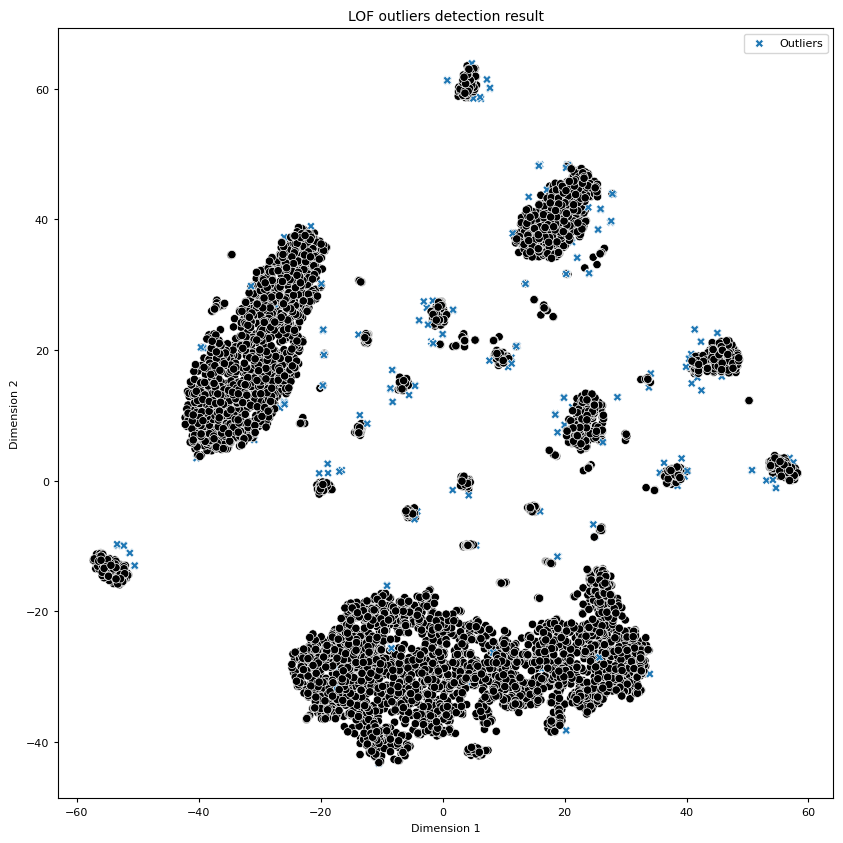

In [57]:
# show LOF results
tSNE_plot(tsne_results, lof_anomalies, title="LOF outliers detection result")

---
---

# One-Class SVM <a class="anchor" id="one-class-svm"></a>

### Apply OCSVM

In [58]:
# turn binary variables into two dummy variables in which we flag just the one corresponding to the true value
X_hot_enc = OneHotEncoder().fit_transform(X[binary]).toarray() # Hot encoding for binary variables to preserve nominal attributes properties
X_hot_enc = DataFrame(X_hot_enc, dtype=int) # turn it into dataframe with binary variables
X_hot_enc = concat([X[continuous], X_hot_enc], axis=1) # concat continuous with the new encoding of binary variables 

In [59]:
# apply ocsvm
X_ocsvm = X_hot_enc.copy()
ocsvm_score = OneClassSVM(kernel="rbf", nu = 0.05).fit_predict(X_ocsvm.to_numpy()) 
# graphical representation is better than LOF, therefore we use a slightly higher contamination (nu) than LOF
ocsvm_anomalies = np.array(ocsvm_score == -1)
# Print the percentage of anomalies
print(f"OCSVM found {ocsvm_anomalies.sum()} anomalies")

OCSVM found 358 anomalies


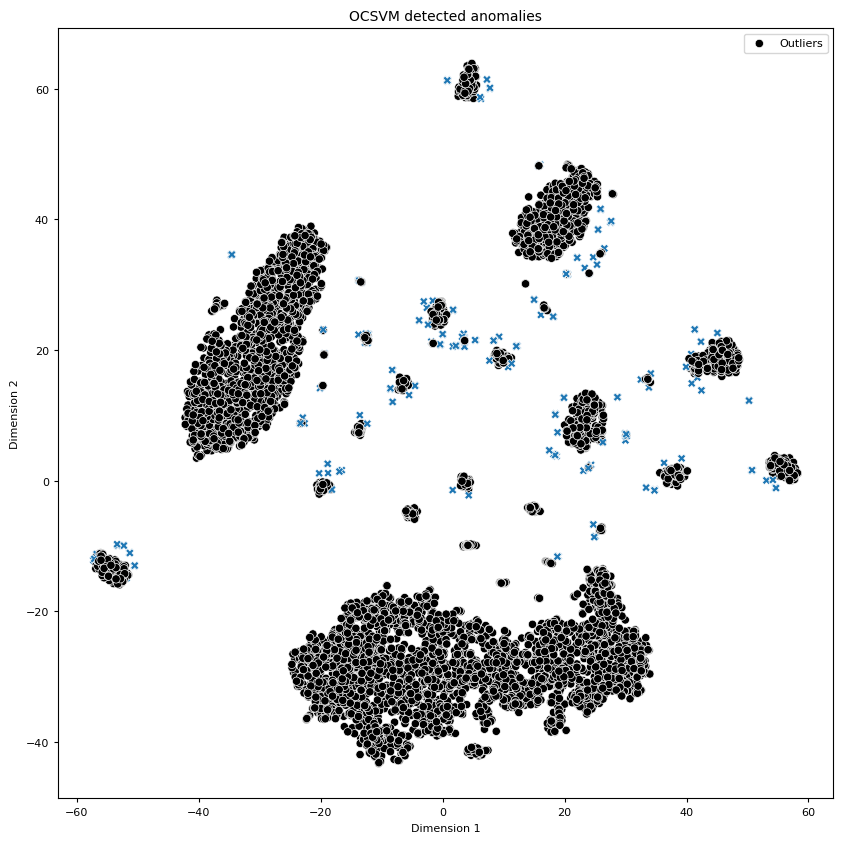

In [60]:
# show OCSVM results
tSNE_plot(tsne_results, ocsvm_anomalies, title="OCSVM detected anomalies")

# Final anomaly score <a class="anchor" id="final-score"></a>

### Unweighted scores

Calculated by giving each method the same weight, even though some methods provide an outlier-ness score

In [62]:
# stack the truth level of detected outlier for the four methods
final_anomalies = np.column_stack([hdbscan_anomalies, lof_anomalies, knn_anomalies, ocsvm_anomalies, if_anomalies])

final_unw_scores= np.zeros(shape=(N,1)).squeeze()
for i,p in enumerate(final_anomalies):
    final_unw_scores[i]=p.mean() # assign the level of outlier-ness as the percentage of outlier votes


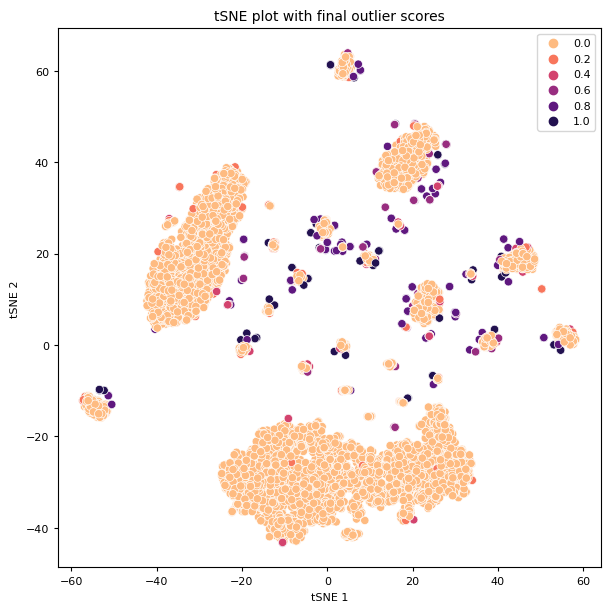

In [63]:
# show tSNE with outliers colors
fig = plt.figure(figsize=(7,7))
PAL = sns.color_palette("magma_r", n_colors=6)
plt.title("tSNE plot with final outlier scores")
sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], hue=np.round(final_unw_scores,2), palette=PAL)
plt.xlabel("tSNE 1")
plt.ylabel("tSNE 2")
plt.show()

fig.savefig("figures/final_unw_scores.jpg")

The percentage of sure inliers is 91.99%


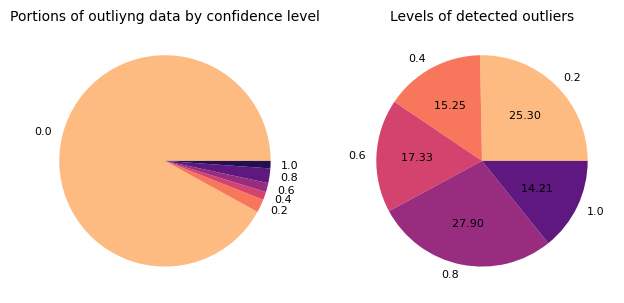

In [64]:
# count the anomalies per confidence level
levels = np.unique(final_unw_scores)
round_levels = [np.round(level, 2) for level in levels] 
counts=[]
for level in levels:
    counts.append((final_unw_scores==level).sum()/N) # percentage of anomalies with certain level

# show how many points are detected as 100% inliers
print(f"The percentage of sure inliers is {100*counts[0]:.2f}%")

# pie charts with proportions
fig = plt.figure()
plt.subplot(1,2,1)
plt.title("Portions of outliyng data by confidence level")
plt.pie(counts, labels = round_levels, colors=PAL)


#plt.pie(counts, labels = levels, colors=PAL)

rlevels = np.delete(round_levels, 0) # do not show inliers
counts.pop(0) # do not show inliers
plt.subplot(1,2,2)
plt.title("Levels of detected outliers")
plt.pie(counts, labels = rlevels, colors=PAL, autopct="%.2f ")
plt.show()

fig.savefig("figures/pie_charts.jpg")

In [65]:
# Print the percentage of anomalies for points with confidence level greater than 0.5
print(f"Percentage of anomalies with confidence level greater than 0.5: {100*np.sum(final_unw_scores>0.5)/N:.2f}%")

Percentage of anomalies with confidence level greater than 0.5: 4.76%


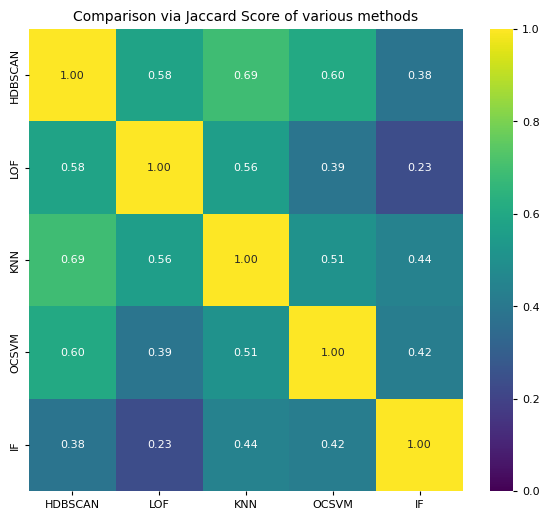

In [66]:
#import jaccard_score
from sklearn.metrics import jaccard_score

jacc_score=[]
n_methods=final_anomalies.shape[1]
# pairwise rand scores for the various methods
for method1 in range(n_methods):
    for method2 in range(method1+1, n_methods):
        jacc_score.append(jaccard_score(final_anomalies[:,method1],final_anomalies[:,method2]))
jacc_score=sf(jacc_score)+np.eye(n_methods) # turn it into a confusion matrix

fig = plt.figure(figsize=(7,6))
plt.title("Comparison via Jaccard Score of various methods")
lbls = ["HDBSCAN", "LOF", "KNN", "OCSVM", "IF"]
sns.heatmap(jacc_score, annot=True, xticklabels=lbls, yticklabels=lbls, cmap="viridis", fmt=".2f", vmin=0)
plt.show()

fig.savefig("figures/jaccard_score.jpg")


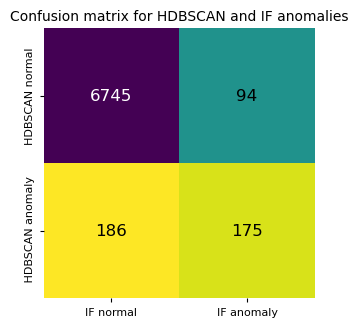

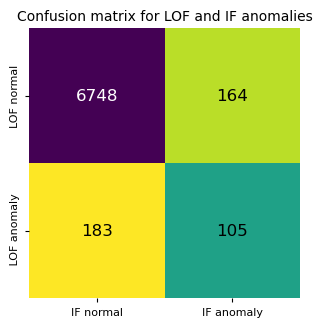

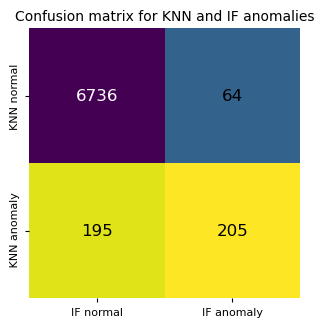

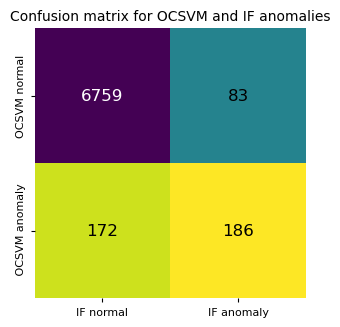

In [69]:
# Write a matrix that compare the how many anomalies are the same for the various methods
# we will use the confusion matrix
from sklearn.metrics import confusion_matrix

# for each method NOT IF
for method in range(4):
    fig = plt.figure(figsize=(3.5,3.5))
    conf_matrix = confusion_matrix(final_anomalies[:,method], final_anomalies[:,-1]) # confusion matrix betw IF and the other method
    plt.title(f"Confusion matrix for {lbls[method]} and {lbls[-1]} anomalies")

    # in this section we adjust the colors and the labels for graphical reasons
    # take coefs
    cf0 = conf_matrix[0,0]
    cf1 = conf_matrix[1,1]
    cf2 = conf_matrix[0,1]
    cf3 = conf_matrix[1,0]

    conf_matrix[0,0] = 0

    # heatmaps are more customizable
    sns.heatmap(conf_matrix, annot=False, cbar = False, yticklabels=[f"{lbls[method]} normal", f" {lbls[method]} anomaly"], xticklabels=["IF normal", "IF anomaly"], cmap="viridis", fmt="d")

    # set text and colors
    plt.text(0.5,0.5,cf0, ha="center", va="center", color="white", fontsize=12)
    plt.text(1.5,1.5,cf1, ha="center", va="center", color="black", fontsize=12)
    plt.text(0.5,1.5,cf3, ha="center", va="center", color="black", fontsize=12)
    plt.text(1.5,0.5,cf2, ha="center", va="center", color="black", fontsize=12)

    plt.show()

    fig.savefig(f"figures/confusion_matrix_{lbls[method]}_IF.jpg")


In [70]:
# save the anomaly scores on the starting dataset
data_raw["Anomaly score"] = final_unw_scores
data_raw.to_csv("Anomaly_scores.csv", index=False)

In [71]:
data_raw.head()

Row     Dim_0  Dim_1=0  Dim_2=0  Dim_3=0  Dim_4=0  Dim_5=0  Dim_6=0  \
0    0  0.750000        1        0        1        1        1        1   
1    1  0.239583        1        1        1        1        1        1   
2    2  0.479167        1        1        1        1        1        1   
3    3  0.656250        0        1        1        1        1        1   
4    4  0.229167        1        1        1        1        1        1   

   Dim_7=0  Dim_8=0  ...  Dim_14=0  Dim_15=0    Dim_16    Dim_17    Dim_18  \
0        1        0  ...         1         1  0.001132  0.080780  0.197324   
1        1        1  ...         1         1  0.000472  0.164345  0.235786   
2        1        1  ...         1         1  0.003585  0.130919  0.167224   
3        1        1  ...         1         1  0.001698  0.091922  0.125418   
4        1        1  ...         1         1  0.000472  0.142061  0.229097   

     Dim_19    Dim_20  Unnamed: 22  Unnamed: 23  Anomaly score  
0  0.300926  0.225000          NaN          NaN            0.6  
1  0.537037  0.165625          NaN          NaN            0.0  
2  0.527778  0.118750          NaN          NaN            0.0  
3  0.337963  0.129688          NaN          NaN            0.0  
4  0.337963  0.235938          NaN          NaN            0.0  

[5 rows x 25 columns]

## Some observation from the starting distributions

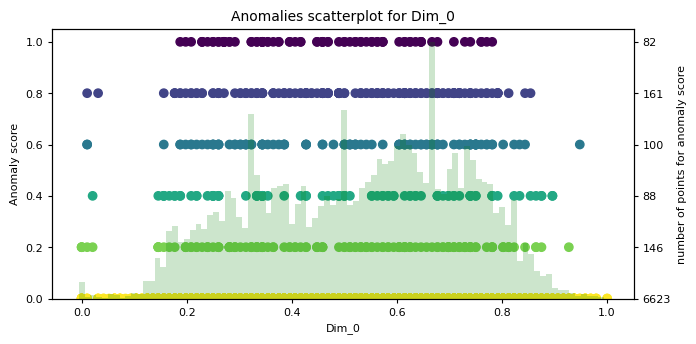

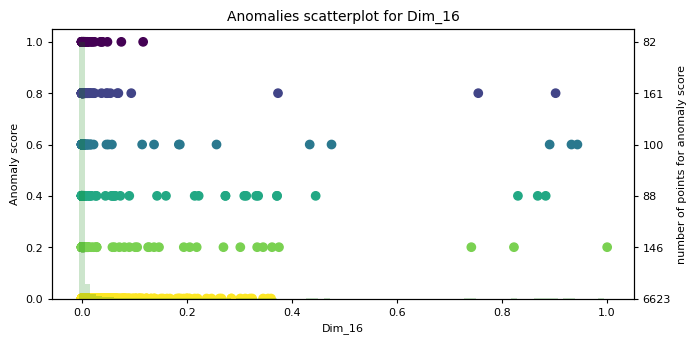

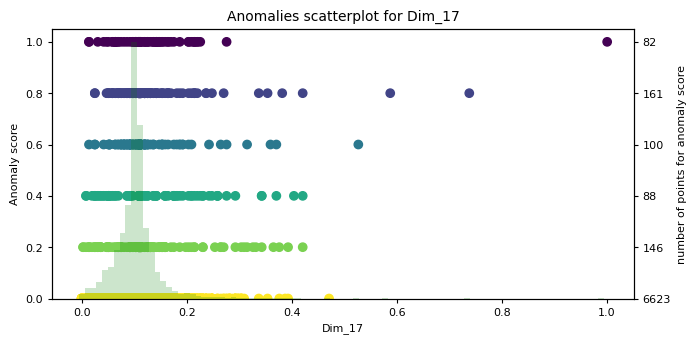

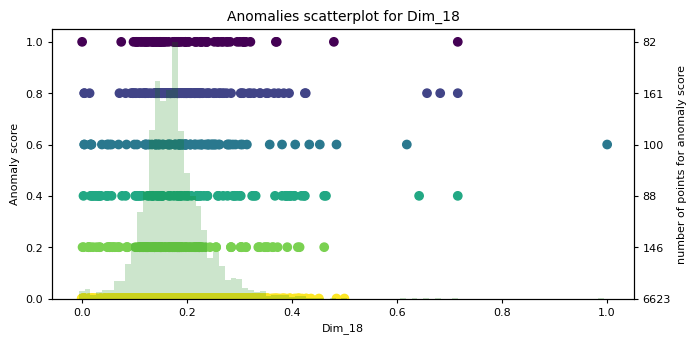

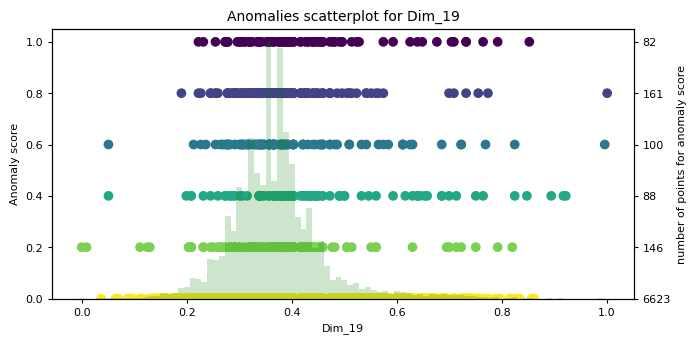

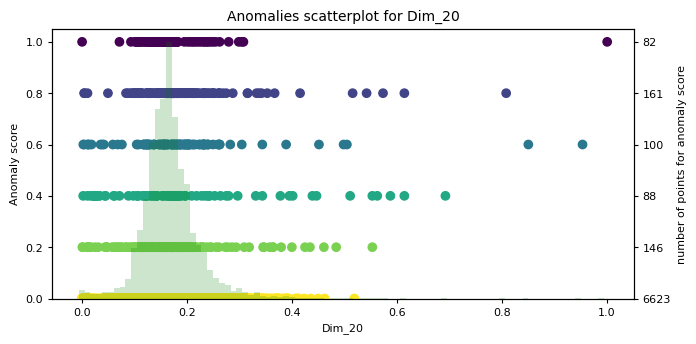

In [75]:
#Do a scatterplot of the anomalies

cols = ["Dim_0","Dim_16", "Dim_17", "Dim_18", "Dim_19", "Dim_20"]


for col in cols:
   
    fig = plt.figure()

    plt.title(f"Anomalies scatterplot for {col}")
    plt.scatter(data_raw[col], data_raw["Anomaly score"], c=data_raw["Anomaly score"], cmap="viridis_r")

    counts, bin_edges = np.histogram(data_raw[col], bins=90, density=True)
    # Normalize the histogram
    max_count = np.max(counts)
    counts_normalized = counts / max_count

    # Plot the normalized histogram
    bin_width = bin_edges[1] - bin_edges[0]
    plt.bar(bin_edges[:-1], counts_normalized, width=bin_width, alpha=0.2, color='g')

    plt.xlabel(col)
    plt.ylabel("Anomaly score")

    # get number of anomalies for each score
    anomaly_counts = []
    for i in levels:
        anomaly_counts.append((data_raw["Anomaly score"]==i).sum())
        

    plt.twinx()
    plt.yticks(levels -0.05,anomaly_counts)
    plt.ylabel("number of points for anomaly score")

    
    plt.show()

    fig.savefig(f"figures/scatterplot_{col}")

